In [1]:
from fastbook import *
from pandas.api.types import is_string_dtype, is_numeric_dtype, is_categorical_dtype
from fastai.tabular.all import *
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np, scipy.stats as st

In [2]:
#Loading the data
L=pd.read_csv("listings.csv")
L.shape

(9231, 75)

### Data preprocessing using TabularPandas and TabularProc for regression and further analyses

piece of preparatory processing is to be sure we can handle strings and missing data. Out of the box, sklearn cannot do either. Instead we will use fastai's class TabularPandas, which wraps a Pandas DataFrame and provides a few conveniences. To populate a TabularPandas, we will use two TabularProcs, Categorify and FillMissing. A TabularProc is like a regular

first we have to drop all the columns that we wont use in our calculations

In [3]:
L.bathrooms_text.unique()

array(['1 bath', nan, '2 baths', '3 baths', '1 shared bath', '0 baths', '1 private bath', '1.5 baths', '1.5 shared baths', '4 baths', '2.5 baths', '6 baths', '2 shared baths', '4.5 shared baths',
       '3 shared baths', '4.5 baths', '5 shared baths', '3.5 baths', '5 baths', '0 shared baths', '2.5 shared baths', 'Private half-bath', '3.5 shared baths', 'Half-bath', '4 shared baths',
       'Shared half-bath', '6 shared baths', '7 shared baths', '28 baths', '8 baths', '10 baths', '11.5 baths', '7 baths', '5.5 baths', '24 baths', '7.5 baths', '8 shared baths'], dtype=object)

In [4]:
L.bathrooms_text=L.bathrooms_text.str.replace("shared","")
L.bathrooms_text=L.bathrooms_text.str.replace("Shared","")
L.bathrooms_text=L.bathrooms_text.str.replace("bath","")
L.bathrooms_text=L.bathrooms_text.str.replace("Private","")
L.bathrooms_text=L.bathrooms_text.str.replace("half-bath","")
L.bathrooms_text=L.bathrooms_text.str.replace("s","")
L.bathrooms_text=L.bathrooms_text.str.replace("private","")
L.bathrooms_text=L.bathrooms_text.str.replace("half-","")
L.bathrooms_text=L.bathrooms_text.str.replace("Half-","")

In [5]:
L["bath"]=L.bathrooms_text

In [6]:
keep_list=columns2=["price","review_scores_value","room_type","instant_bookable","host_identity_verified","number_of_reviews","beds","bath","bedrooms","reviews_per_month","neighbourhood_cleansed","property_type","availability_30","availability_60","availability_90","availability_365"]
listings=L[keep_list]

In [7]:
listings.head()

,price,review_scores_value,room_type,instant_bookable,host_identity_verified,number_of_reviews,beds,bath,bedrooms,reviews_per_month,neighbourhood_cleansed,property_type,availability_30,availability_60,availability_90,availability_365
0,320.591862,4.75,Entire home/apt,f,t,12,2.0,1,1.0,0.54,Providencia,Entire rental unit,0,0,0,216
1,53.092478,NaN,Private room,t,t,0,1.0,NaN,1.0,NaN,Providencia,Private room in rental unit,28,58,88,178
2,54.093711,4.44,Entire home/apt,f,t,45,1.0,1,1.0,0.43,Providencia,Entire rental unit,1,2,2,2
3,184.955610,4.68,Entire home/apt,f,t,38,8.0,2,2.0,0.59,Lo Barnechea,Entire rental unit,30,60,90,365
4,86.313194,5.00,Entire home/apt,f,t,2,4.0,2,2.0,0.03,Providencia,Entire rental unit,30,60,90,365


TabularPandas needs to be told which columns are continuous and which are categorical. We can handle that automatically using the helper function cont_cat_split:

In [8]:
dep_var="price"

In [9]:
cont,cat = cont_cat_split(listings, 1, dep_var=dep_var)

In [10]:
procs = [Categorify, FillMissing]
to = TabularPandas(listings, procs, cat, cont, y_names=dep_var)

### 1.What are the proportions of apartments per neighbourhood?

In [11]:
### number of neighbourhoods in the data
print(len(listings.neighbourhood_cleansed.unique()))

31


There are 31 neighbourhouds in our data

In [12]:
aparts = listings.groupby('neighbourhood_cleansed')['neighbourhood_cleansed'].count()
ap = pd.DataFrame(aparts)
values_ =ap.iloc[:,-1].values.sum()
solution= values_/31
solution

297.7741935483871

The average number of apartments per neighbourhoud is 297.77.

### 2.What are the proportions of apartment per apartment type?

In [13]:
aparts2 = listings.groupby('property_type')['property_type'].count()
aparts2.sum()/len(listings.property_type.unique())

116.84810126582279

The average number of apartments per apartment type is 116.84.

### 3.What are proportions of apartment types for the three biggest neighbourhoods?

In [18]:
aparts3 = listings.groupby('neighbourhood_cleansed')['neighbourhood_cleansed'].count()
aparts3 = pd.DataFrame(aparts3)
aparts3

,neighbourhood_cleansed
neighbourhood_cleansed,
Cerrillos,10
Cerro Navia,8
Conchalí,8
El Bosque,5
Estación Central,133
Huechuraba,44
Independencia,56
La Cisterna,31
La Florida,114


The three biggest neighbourhouds are:

1 - Santiago               3101

2 - Providencia            1751

3 - Las Condes             1467

In [19]:
top = ['Santiago','Providencia','Las Condes' ]
top3 = listings[listings.neighbourhood_cleansed.isin(top)]
top3.neighbourhood_cleansed.unique()

array(['Providencia', 'Santiago', 'Las Condes'], dtype=object)

In [20]:
apart_types = top3.groupby(['neighbourhood_cleansed','property_type'])['property_type'].count()
apart_types.sort_values(ascending=False)
aparts_df=pd.DataFrame(apart_types)
aparts_df

property_type
neighbourhood_cleansed property_type                                   
Las Condes             Dome house                                     1
                       Entire cabin                                   1
                       Entire chalet                                  1
                       Entire condominium (condo)                    68
                       Entire guest suite                             5
...                                                                 ...
Santiago               Shared room in hostel                          7
                       Shared room in rental unit                    40
                       Shared room in residential home               11
                       Shared room in serviced apartment              3
                       Shared room in tiny house                      2

[131 rows x 1 columns]

### 4.What appartements in the top five neighbourhoods give the biggest profits per bed?

Had to save and reload the CSV otherwise, we would have lost some values

In [21]:
beds2=pd.read_csv("beds.csv")
beds2.beds=beds2.beds.astype(float)

In [22]:
# add profit_per_bed column
beds2['profit_per_bed'] = beds2.price/beds2.beds
beds2.profit_per_bed.mean()

58.485793607024526

In [23]:
appar_prof = beds2.groupby(['neighbourhood_cleansed','property_type'])['profit_per_bed'].max()
prof = pd.DataFrame(appar_prof)
prof.reset_index(inplace=True)
prof = prof.sort_values(ascending=False, by = 'profit_per_bed').head(14)
prof

,neighbourhood_cleansed,property_type,profit_per_bed
234,Providencia,Entire rental unit,32556.696671
263,Providencia,Shared room in rental unit,30052.335388
186,Macul,Private room in rental unit,22946.494451
124,Las Condes,Private room in rental unit,10017.445129
251,Providencia,Private room in rental unit,10017.445129
96,La Reina,Private room in rental unit,10017.445129
446,Ñuñoa,Private room in rental unit,10007.427867
300,Recoleta,Entire rental unit,9143.092478
430,Ñuñoa,Entire rental unit,8041.701603
392,Santiago,Shared room in condominium (condo),8015.043157


top appartements in the top five neighbourhoods are :

1- Entire rental unit with in Providencia for 32556.0$

2- Shared room in rental unit in Providencia for with 30052.0$

3- Private room in rental unit in Macul for 22946.0$

4- Private room in rental unit in Las Condes for with 10017$

5- Private room in rental unit in Providencia for with 10017$

these are obviously outliers in our data, above we checked the mean profit per bed and it's 58.48 which is reasonable

### 5.Is there a difference in price between apartments listed for more than 50 days and those who are listed less than 50 days?

we don't quiet understand the question, for example appartment with ID 455, is availible for 30,60,90, and 365 days respectfully, so we chose column availibilty90 to be the cut off point

we did some data processing on excel mainly removing the empty values from bath column and transforming it from str to float

In [24]:
data2=pd.read_excel("Data2.xlsx")

In [25]:
data2.bath.unique()

array([ 1. ,  2. ,  3. ,  1.5,  4. ,  2.5,  6. ,  4.5,  5. ,  3.5,  7. , 28. ,  8. , 10. , 11.5,  5.5, 24. ,  7.5])

In [26]:
data2.bath=data2.bath.astype(float)

In [27]:
# add profit_per_bed and profit_per_bath column
data2['profit_bed'] = data2.price/data2.beds
data2['profit_bath'] = data2.price/data2.bath

In [28]:
m50 = data2[data2.availability_90 >=50]
p50 = data2[data2.availability_60<50]
m50p=m50["price"].mean()
p50p=p50["price"].mean()

In [29]:
m50p, p50p

(112.50012990480617, 60.70244923018297)

we can see that the mean of the two categories varies alot, so that means there's a difference in the price

### 6.Is there a difference in price between unitsd (only) with two bedrooms listed for more than 50 days and those who are listed less than 50 days?

In [30]:
bed3 = data2[data2.bedrooms == 2]
twob_m50 = bed3[bed3.availability_90 >=50]
twob_p50 = bed3[bed3.availability_60<50]
dm50p=twob_m50["price"].mean()
dp50p=twob_p50["price"].mean()

In [31]:
dm50p, dp50p

(180.57514086797062, 72.65020591476156)

the difference is more flagrant in appartments with two or more bedrooms listed

### 7.Calculate confidence intervals price per bed and for price per bathrooms for the city as whole and for the top three neighbourhoods.

In [32]:
# for price per beds whole data
st.t.interval(0.95, len(data2.profit_bed)-1, loc=np.mean(data2.profit_bed), scale=st.sem(data2.profit_bed))

(45.29330388933306, 71.59543880883713)

We are 95% confident that the price per bed in Santiago Airbnb is between 45.29 and 71.59.

In [33]:
# for price per bath whole data
st.t.interval(0.95, len(data2.profit_bath)-1, loc=np.mean(data2.profit_bath), scale=st.sem(data2.profit_bath))

(55.312828671673756, 89.30324150836275)

We are 95% confident that the price per bath in Santiago Airbnb is between 55.31 and 89.30.

In [34]:
# top 3
top3 = data2[data2.neighbourhood_cleansed.isin(top)]
top3.neighbourhood_cleansed.unique()

array(['Providencia', 'Santiago', 'Las Condes'], dtype=object)

In [35]:
#for price per beds for top 3
st.t.interval(0.95, len(top3.profit_bed)-1, loc=np.mean(top3.profit_bed), scale=st.sem(top3.profit_bed))

(38.99104046733004, 71.06564755554726)

We are 95% confident that the price per bed in top three neighbourhouds is between 38.99 and 71.06.

In [36]:
#for price per bath for top 3
st.t.interval(0.95, len(top3.profit_bath)-1, loc=np.mean(top3.profit_bath), scale=st.sem(top3.profit_bath))

(43.947381685793204, 90.62043005483218)

We are 95% confident that the price per bath in top three neighbourhouds is between 43.94 and 90.61.

### 9.Define hypothesis tests for prices per neighbourhood and reviews per month. 

Hypothesis:
- Null hypothsis A : neighbourhoud has no influence over price.
- Null hypothsis B : reviews per month has no influence over price.

#### Neibourhoud has no influence over price

In [37]:
##determine the average price for all the population
data2.price.mean()

97.8864182103148

In [38]:
### take one simple for one neighbourhood
St=["Santiago"]
Santiago= data2[data2.neighbourhood_cleansed.isin(St)]
Santiago.price.mean()

49.97877039073373

In [39]:
st.ttest_1samp(a = Santiago.price ,popmean = data2.price.mean())

Ttest_1sampResult(statistic=-13.374188062450804, pvalue=1.2183699540496165e-39)

The T statistic of -13.137 tells us how the sample mean deviates from the population mean, more importantly we have a P value, which tells us the probability of getting these two different means due to chance, is 1.2183699540496165e-39 a number so small, it's practicly insignifcant. In conclusion we reject the null hypothesis, we can even go as far as accepting the alternative hypothesis, will be demonstrated later

#### reviews per month has no influence over price.

In [40]:
##check the number of average reviews per month, it will be our cut off point for a sample
data2.reviews_per_month.mean()

0.8502965874575693

In [41]:
##taking the sample 
high_reviews= data2[data2.reviews_per_month > 0.85]

In [42]:
high_reviews.price.mean()

52.68806824724944

In [43]:
st.ttest_1samp(high_reviews.price, popmean=data2.price.mean())

Ttest_1sampResult(statistic=-42.01789233000101, pvalue=1.3704567501342862e-267)

The T statistic of -42.02 tells us how the sample mean deviates from the population mean, more importantly we have a P value, which tells us the probability of getting these two different means due to chance, is 1.3704567501342862e-267 a number so small, it's practicly insignifcant. In conclusion we reject the null hypothesis

### 10.Test unpaired sample means for prices per bed from different neighbourhoods and check if there is a difference in mean or not.

In [44]:
ms = data2.groupby('neighbourhood_cleansed')['profit_bed'].mean()
ms = pd.DataFrame(ms).reset_index()
ms = ms.sample(15)

In [45]:
fig = plt.figure()
sns.set(rc={'figure.figsize':(12,9)})

<Figure size 432x288 with 0 Axes>

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14]),
 [Text(0, 0, 'San Miguel'),
  Text(1, 0, 'Lo Prado'),
  Text(2, 0, 'Quinta Normal'),
  Text(3, 0, 'Maipú'),
  Text(4, 0, 'La Florida'),
  Text(5, 0, 'La Granja'),
  Text(6, 0, 'Vitacura'),
  Text(7, 0, 'Recoleta'),
  Text(8, 0, 'Las Condes'),
  Text(9, 0, 'Cerrillos'),
  Text(10, 0, 'Estación Central'),
  Text(11, 0, 'Macul'),
  Text(12, 0, 'Huechuraba'),
  Text(13, 0, 'Lo Barnechea'),
  Text(14, 0, 'La Reina')])

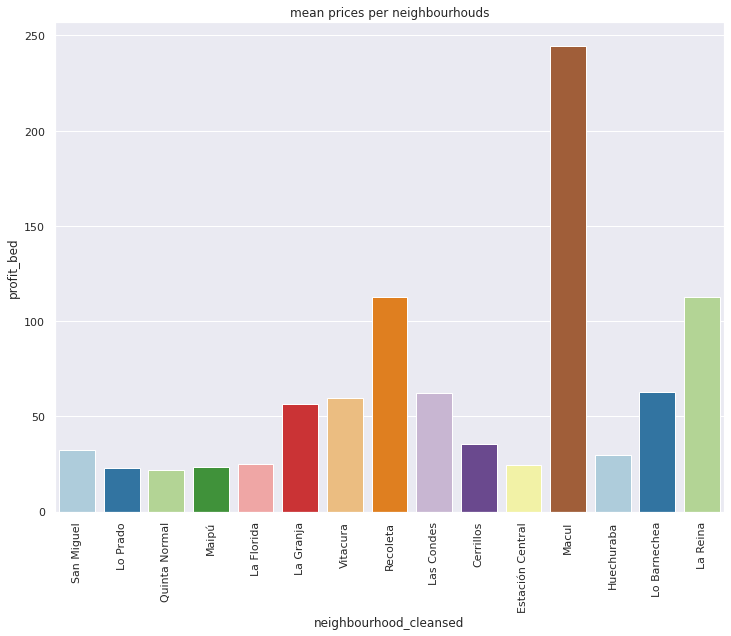

In [46]:
sns.barplot(x= ms.neighbourhood_cleansed, y = ms.profit_bed, palette="Paired").set_title('mean prices per neighbourhouds')
plt.xticks(rotation=90)

as you can see in this graph, there's a significant change in the mean depending on the neighbourhood

### 11.Calculate correlations  between the  prices, number of bathrooms, bedrooms, beds and neighbourhood.

In [47]:
cor_list=["price","beds","bath","bedrooms","neighbourhood_cleansed"]
corr=data2[cor_list]

In [48]:
CorMat=corr.corr()

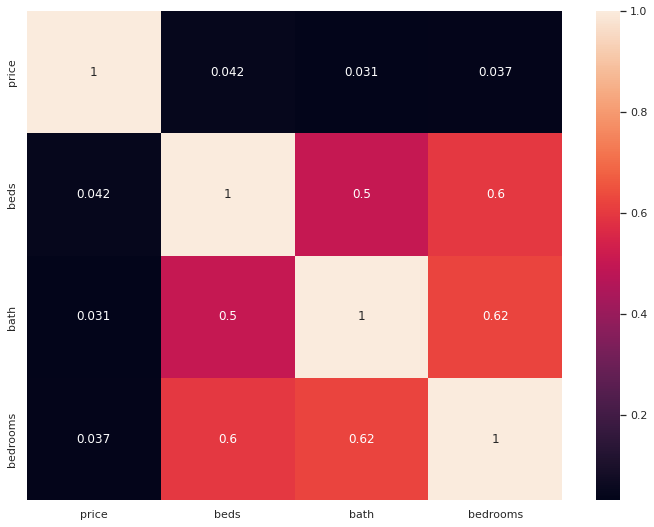

In [49]:
sns.heatmap(CorMat, annot=True)
plt.show()

### 12.Regression - What predicts Airbnb rental prices? Number of beds?  Number of bathrooms? Review scores? Other? Suggest a linear regressions and answers the question. & BONUS QUESTION

We chose to do a more complex form of regression, a RandomForest, we did this because with Fastai and TabularPandas, it will allow us to show you some cool features

In [50]:
xs,y = to.train.xs,to.train.y

In [51]:
def rf(xs, y, n_estimators=40, max_samples=9200,
       max_features=0.5, min_samples_leaf=5, **kwargs):
    return RandomForestRegressor(n_jobs=-1, n_estimators=n_estimators,
        max_samples=max_samples, max_features=max_features,
        min_samples_leaf=min_samples_leaf, oob_score=True).fit(xs, y)

In [52]:
m = rf(xs,y);

/opt/conda/lib/python3.7/site-packages/sklearn/base.py:442: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  "X does not have valid feature names, but"


#### Feature Importance

In [53]:
def rf_feat_importance(m, df):
    return pd.DataFrame({'cols':df.columns, 'imp':m.feature_importances_}
                       ).sort_values('imp', ascending=False)

In [54]:
fi = rf_feat_importance(m, xs)
fi[:10]

,cols,imp
18,availability_365,0.198508
4,neighbourhood_cleansed,0.128412
12,beds,0.116638
3,bath,0.069538
5,property_type,0.069142
16,availability_60,0.067113
17,availability_90,0.060283
11,number_of_reviews,0.055214
9,reviews_per_month_na,0.047120
1,instant_bookable,0.043934


<AxesSubplot:ylabel='cols'>

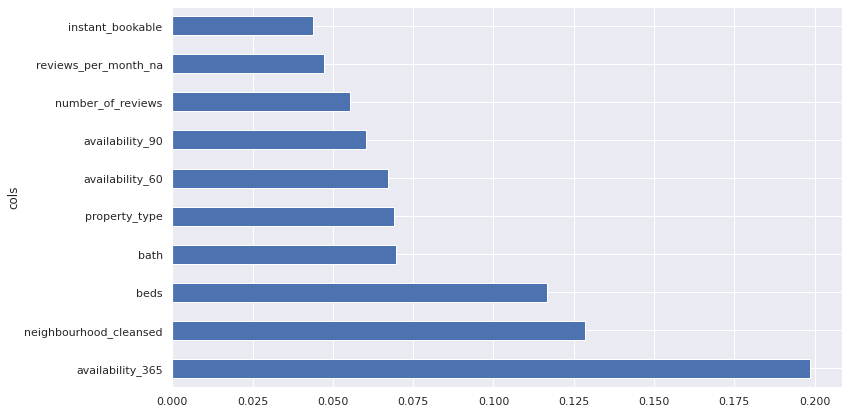

In [55]:
def plot_fi(fi):
    return fi.plot('cols', 'imp', 'barh', figsize=(12,7), legend=False)

plot_fi(fi[:10])

In the grave above we can see which feature infleunce price the most, in first place we got something unexpected, it's availability thats the most important feature followed by the neighbourhood and the number of beds. then we can see which features are redundant thanks to this Fastai's cluster_columns function, by redundant, we mean features that had smillar effects on price according to the model

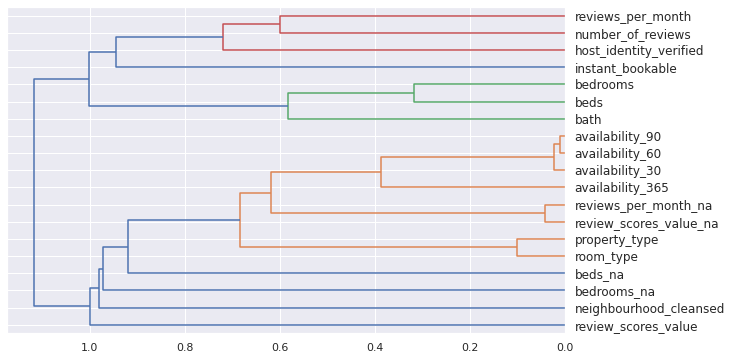

In [56]:
cluster_columns(xs)